# Price Analysis New


In [44]:
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
#I want to plot output price vs release date
import matplotlib.pyplot as plt

#read in csv file and convert to pandas dataframe
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, QuantileRegressor



In [45]:

df = pd.read_csv('art_analysis_scrape.csv')

#print the first 5 rows of the dataframe
# print(df.head())
print(df.columns)

# Convert 'release_date' to datetime if it's not already
#filter out nan values  

#filter based on 
df = df[df['Output Price\nUSD/1M Tokens'].notna()]
df = df[df['Release Date'].notna()]
df['Release Date'] = pd.to_datetime(df['Release Date'])

# Convert price to float - handle the case where it might not be a string
# First check if the column contains strings
if df['Output Price\nUSD/1M Tokens'].dtype == 'object':
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
else:
    # If it's already numeric, just ensure it's float type
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].astype(float)

#make a column of called active parameters if Know active parameters is available use that, otherwise use params
# Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)




#collect output price for models with open licenses
open_license_df = df[df['License'] == 'Open']
proprietary_df = df[df['License'] == 'Proprietary']

Index(['Model', 'Creator', 'License', 'Context\nWindow',
       'Artificial Analysis\nIntelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
       'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
       'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
       'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
       'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
       'Further\nAnalysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Lowest Output Price Found 

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_35331/3691677180.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


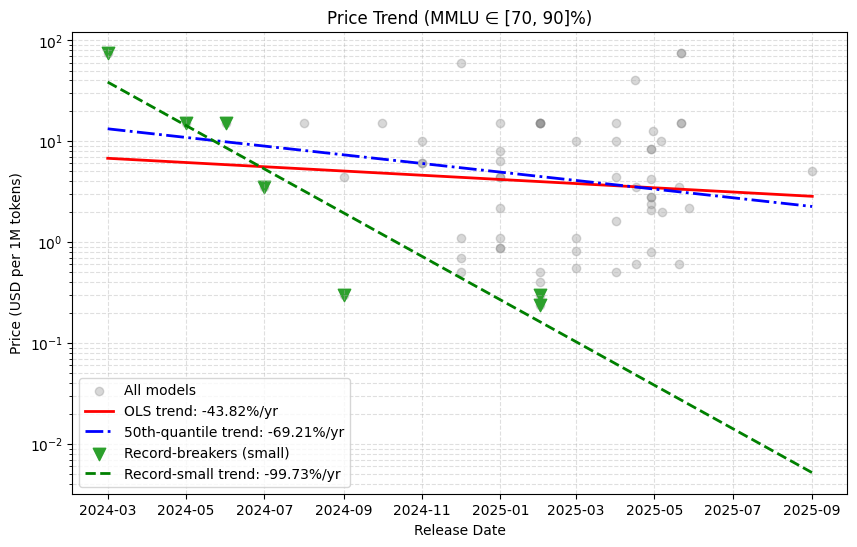

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

# 0) Bounds & column names
min_mmlu = 70
max_mmlu = 90
mmlu_col = 'MMLU-Pro (Reasoning & Knowledge)'
price_col = 'Output Price\nUSD/1M Tokens'

# 1) Convert MMLU “XX%” → float
df[mmlu_col] = (
    df[mmlu_col].astype(str)
                .str.replace('%','',regex=False)
                .astype(float)
)

# 2) Convert price “$X,XXX” → float
df[price_col] = (
    df[price_col].astype(str)
                 .str.replace('[$,]','',regex=True)
)
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

# 3) Filter to MMLU range & drop missing
df_sub = df[df[mmlu_col].between(min_mmlu, max_mmlu)].copy()
df_sub = df_sub.dropna(subset=['Release Date', price_col])

# 4) Remove non-positive prices to avoid -inf in log10
df_sub = df_sub[df_sub[price_col] > 0]

# 5) Sort by Release Date & compute ordinal
df_sub = df_sub.sort_values('Release Date')
df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

# 6) Prepare X, y_log
X = df_sub['Date_Ordinal'].values.reshape(-1, 1)
y_log = np.log10(df_sub[price_col].values)

# 7) Fit overall OLS on log(price)
model_all = LinearRegression().fit(X, y_log)

# 8) Fit median (τ=0.5) Quantile Regression on log(price)
quantile = 0.5
qr = QuantileRegressor(quantile=quantile, alpha=0.0).fit(X, y_log)

# 9) Build daily grid for predictions
min_ord = df_sub['Date_Ordinal'].min()
max_ord = df_sub['Date_Ordinal'].max()
x_range = np.arange(min_ord, max_ord + 1)
x_dates = [datetime.fromordinal(int(d)) for d in x_range]

y_ols_log = model_all.predict(x_range.reshape(-1,1))
y_qr_log  = qr.predict(x_range.reshape(-1,1))

# 10) Compute annualized % growth
coef_ols     = model_all.coef_[0]
annual_pct_ols = ((10**coef_ols)**365 - 1) * 100
coef_qr      = qr.coef_[0]
annual_pct_qr  = ((10**coef_qr)**365 - 1) * 100

# 11) Identify “record‐breaking small” (running minima of price)
df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
record_small = df_sub[df_sub['Is_Record_Small']].copy()

# 12) Fit OLS on the record‐small points
X_rec      = record_small['Date_Ordinal'].values.reshape(-1,1)
y_rec_log  = np.log10(record_small[price_col].values)
model_rec  = LinearRegression().fit(X_rec, y_rec_log)
y_rec_log_pred = model_rec.predict(x_range.reshape(-1,1))
coef_rec    = model_rec.coef_[0]
annual_pct_rec = ((10**coef_rec)**365 - 1) * 100

# 13) Plot everything
plt.figure(figsize=(10,6))

# a) All points
plt.scatter(
    df_sub['Release Date'], df_sub[price_col],
    color='gray', alpha=0.3, label='All models'
)

# b) Overall OLS trend
plt.plot(
    x_dates, 10**y_ols_log,
    'r-', lw=2,
    label=f'OLS trend: {annual_pct_ols:.2f}%/yr'
)

# c) Median quantile trend
plt.plot(
    x_dates, 10**y_qr_log,
    'b-.', lw=2,
    label=f'{quantile*100:.0f}th-quantile trend: {annual_pct_qr:.2f}%/yr'
)

# d) Record‐small points
plt.scatter(
    record_small['Release Date'], record_small[price_col],
    color='tab:green', s=80, marker='v',
    label='Record-breakers (small)'
)

# e) Record‐small OLS trend
plt.plot(
    x_dates, 10**y_rec_log_pred,
    'g--', lw=2,
    label=f'Record-small trend: {annual_pct_rec:.2f}%/yr'
)

plt.yscale('log')
plt.xlabel('Release Date')
plt.ylabel('Price (USD per 1M tokens)')
plt.title(f'Price Trend (MMLU ∈ [{min_mmlu}, {max_mmlu}]%)')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.legend()
plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

def plot_price_trend_by_mmlu(min_mmlu, max_mmlu, open_license_only=False, quantile=0.2):
    """
    Plot price‐per‐1M-token trends for models with MMLU in [min_mmlu, max_mmlu].
    If open_license_only=True, only keep rows where `license_col` contains 'open' (case‐insensitive).
    Assumes `df` is in scope with columns:
      - 'Release Date' (datetime64)
      - 'MMLU-Pro (Reasoning & Knowledge)' (e.g. "75%")
      - 'Output Price\nUSD/1M Tokens' (e.g. "$0.50")
      - license_col (e.g. 'License')
    
    Parameters:
      min_mmlu: Minimum MMLU score to include
      max_mmlu: Maximum MMLU score to include
      open_license_only: If True, only include models with open licenses
      quantile: Quantile level for the quantile regression (default: 0.5 for median)
    """
    # --- column names ---
    mmlu_col    = 'MMLU-Pro (Reasoning & Knowledge)'
    price_col   = 'Output Price\nUSD/1M Tokens'
    license_col = 'License'   # ← adjust if your CSV uses a different header

    # 1) Work on a copy
    df_work = df.copy()

    # 2) Convert MMLU "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%','',regex=False)
                         .astype(float)
    )

    # 3) Convert price "$X,XXX" → float
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]','',regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')

    # 4) Optionally filter to open‐license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 5) Filter to MMLU range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 6) Drop missing Release Date or price, remove non‐positive prices
    df_sub = df_sub.dropna(subset=['Release Date', price_col])
    df_sub = df_sub[df_sub[price_col] > 0]

    # 7) Sort & compute ordinal date
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 8) Prepare regressions on log10(price)
    X     = df_sub['Date_Ordinal'].values.reshape(-1,1)
    y_log = np.log10(df_sub[price_col].values)

    # overall OLS
    ols = LinearRegression().fit(X, y_log)
    # quantile regression with specified quantile
    qr  = QuantileRegressor(quantile=quantile, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.arange(min_ord, max_ord + 1)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]

    y_ols_log = ols.predict(x_range.reshape(-1,1))
    y_qr_log  = qr.predict(x_range.reshape(-1,1))

    # 10) Compute annualized % growth
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100

    # 11) "Record‐small" = running minima of price
    df_sub['Is_Record_Small'] = df_sub[price_col].cummin() == df_sub[price_col]
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # OLS on those
    X_rec         = record_small['Date_Ordinal'].values.reshape(-1,1)
    y_rec_log     = np.log10(record_small[price_col].values)
    rec_ols       = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100

    # 12) Plot
    plt.figure(figsize=(10,6))
    # all
    plt.scatter(df_sub['Release Date'], df_sub[price_col],
                color='gray', alpha=0.3, label='All models')
    # OLS trend
    plt.plot(x_dates, 10**y_ols_log, 'r-', lw=2,
             label=f'OLS trend: {annual_pct_ols:.2f}%/yr')
    # specified quantile
    plt.plot(x_dates, 10**y_qr_log, 'b-.', lw=2,
             label=f'{quantile*100:.0f}th-quantile: {annual_pct_qr:.2f}%/yr')
    # record-small points
    plt.scatter(record_small['Release Date'], record_small[price_col],
                color='tab:green', s=80, marker='v',
                label='Record-small points')
    # record-small trend
    plt.plot(x_dates, 10**y_rec_log_pred, 'g--', lw=2,
             label=f'Record-small trend: {annual_pct_rec:.2f}%/yr')

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Price (USD per 1M tokens)')
    lic_label = 'open‐license only' if open_license_only else 'all licenses'
    plt.title(f'Price Trend (MMLU ∈ [{min_mmlu},{max_mmlu}]%, {lic_label})')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()

# Example usage:
# plot_price_trend_by_mmlu(50, 70, open_license_only=True, quantile=0.2)

# Look At Trend Across All Groups

## Low End Model Group

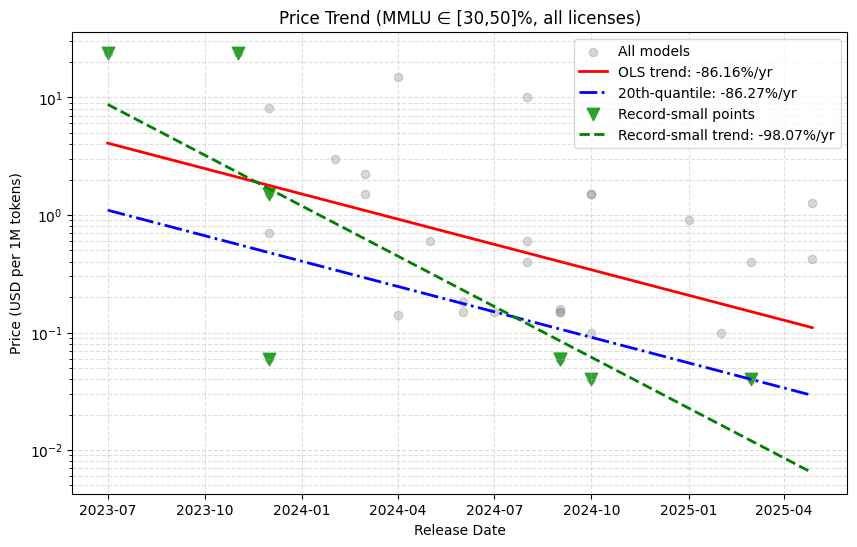

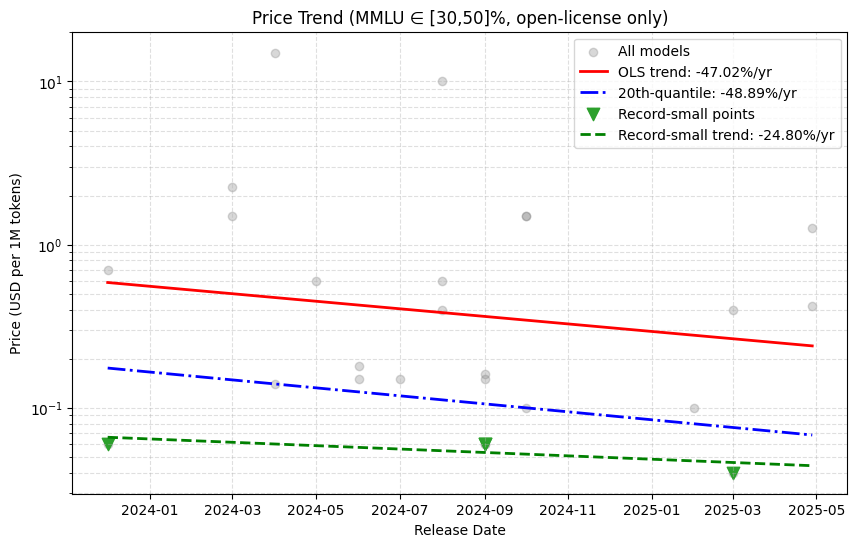

In [16]:
plot_price_trend_by_mmlu(30, 50, open_license_only=False, quantile=0.2)
plot_price_trend_by_mmlu(30, 50, open_license_only=True, quantile=0.2)


## Medium Level Trend

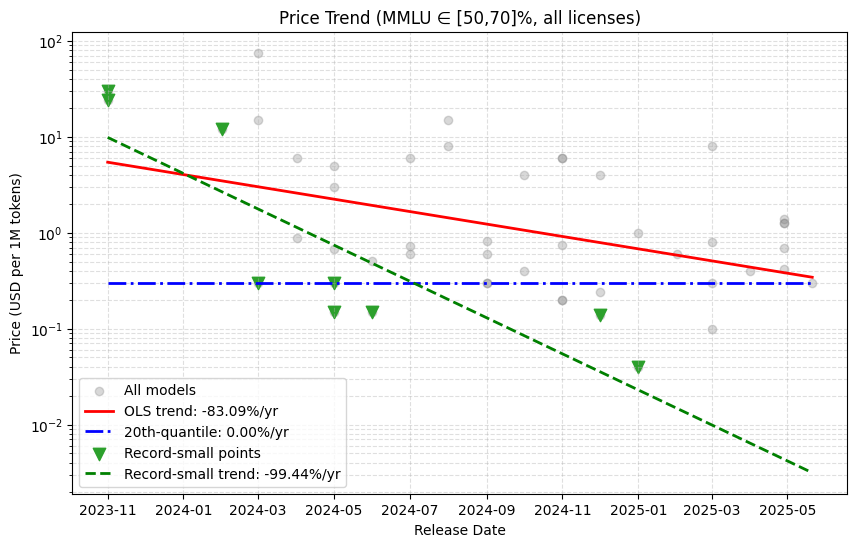

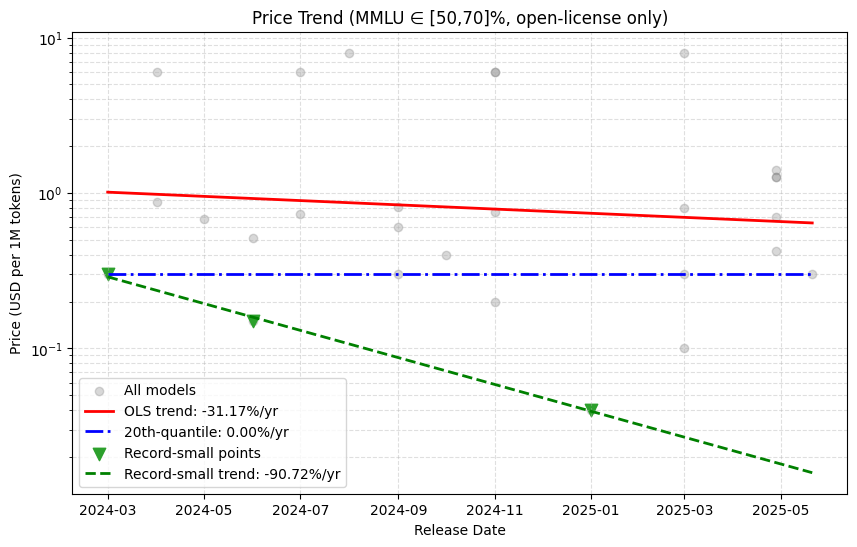

In [17]:
plot_price_trend_by_mmlu(50, 70, open_license_only=False, quantile=0.2)
plot_price_trend_by_mmlu(50, 70, open_license_only=True, quantile=0.2)

## High End Model Group

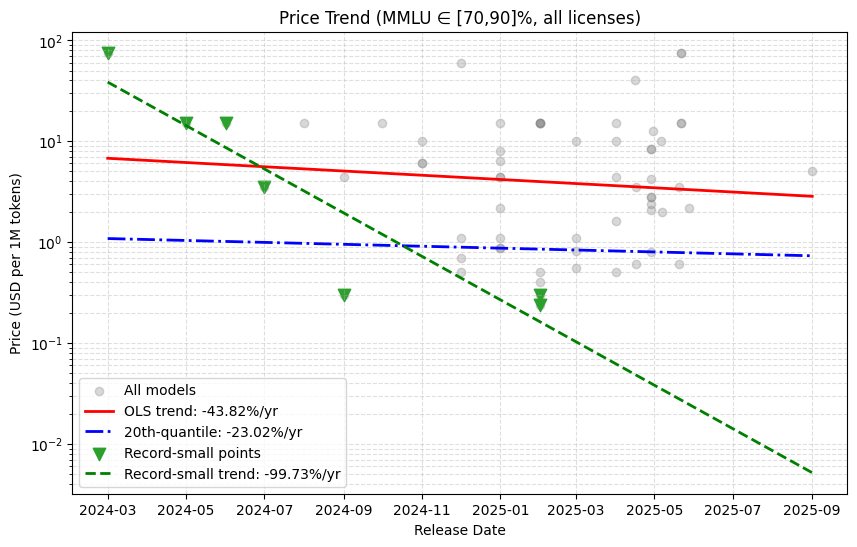

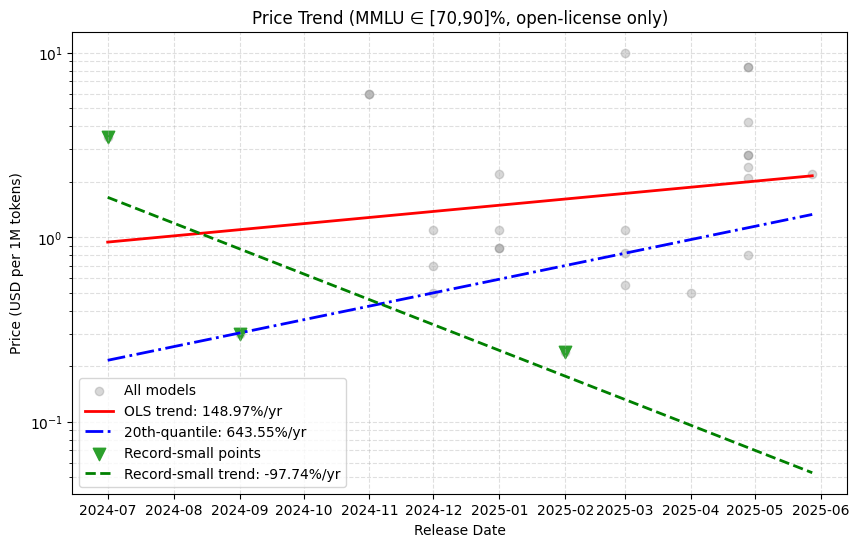

In [20]:
plot_price_trend_by_mmlu(70, 90, open_license_only=False, quantile=0.2)
plot_price_trend_by_mmlu(70, 90, open_license_only=True, quantile=0.2)

## Parameter Trends

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

def plot_params_small_trend_by_mmlu(min_mmlu, max_mmlu, open_license_only=False, benchmark_name='MMLU-Pro (Reasoning & Knowledge)', use_active_params=False):
    """
    Plot number-of-parameters (in billions) vs. release date for models
    with benchmark score ∈ [min_mmlu, max_mmlu], and highlight the record-small trend
    (running minima of model size).
    
    Parameters:
    - min_mmlu, max_mmlu: numeric bounds on benchmark score (%)
    - open_license_only: if True, only include rows where 'License' contains 'open'
    - benchmark_name: name of the benchmark column to use (default: 'MMLU-Pro (Reasoning & Knowledge)')
    - use_active_params: if True, use 'Active Parameters' column instead of 'Parameters'
    
    Assumes `df` is in scope with columns:
      - 'Release Date' (datetime64)
      - benchmark_name (e.g. '75%')
      - 'Parameters' or 'Active Parameters' (absolute count)
      - 'License' (string)
    """
    # column names
    mmlu_col    = benchmark_name
    param_col   = 'Active Parameters' if use_active_params else 'Parameters'  # choose parameter column
    license_col = 'License'             # adjust if needed

    # work on a copy
    df_work = df.copy()

    # 1) Convert benchmark score "XX%" → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%', '', regex=False)
                         .astype(float)
    )

    # 2) Convert parameter counts → numeric; scale to billions
    df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')
    df_work['Params_B'] = df_work[param_col] / 1e9

    # 3) Optionally filter to open-licensed models
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 4) Filter to benchmark score range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 5) Drop missing dates or sizes; remove non-positive sizes
    df_sub = df_sub.dropna(subset=['Release Date', 'Params_B'])
    df_sub = df_sub[df_sub['Params_B'] > 0]

    # 6) Sort & compute ordinal dates
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 7) Prepare X, y (log10 of Params_B)
    X     = df_sub['Date_Ordinal'].values.reshape(-1, 1)
    y_log = np.log10(df_sub['Params_B'].values)

    # 8) Fit overall OLS & median QuantileRegressor
    ols = LinearRegression().fit(X, y_log)
    qr  = QuantileRegressor(quantile=0.5, alpha=0.0).fit(X, y_log)

    # 9) Build daily grid for predictions
    lo, hi    = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range   = np.arange(lo, hi + 1)
    x_dates   = [datetime.fromordinal(int(d)) for d in x_range]
    y_ols_log = ols.predict(x_range.reshape(-1, 1))
    y_qr_log  = qr.predict(x_range.reshape(-1, 1))

    # 10) Annualized growth rates
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100

    # 11) Identify record-small points (running minima of size)
    df_sub['Is_Record_Small'] = df_sub['Params_B'].cummin() == df_sub['Params_B']
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # 12) Fit OLS on record-small points
    X_rec          = record_small['Date_Ordinal'].values.reshape(-1, 1)
    y_rec_log      = np.log10(record_small['Params_B'].values)
    rec_ols        = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1, 1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100

    # 13) Plot
    plt.figure(figsize=(10, 6))

    # a) All models
    plt.scatter(
        df_sub['Release Date'], df_sub['Params_B'],
        color='gray', alpha=0.3, label='All models'
    )
    # b) Overall OLS trend
    plt.plot(
        x_dates, 10**y_ols_log,
        'r-', lw=2, label=f'OLS trend: {annual_pct_ols:.2f}%/yr'
    )
    # c) Median quantile trend
    plt.plot(
        x_dates, 10**y_qr_log,
        'b-.', lw=2, label=f'50th-quantile trend: {annual_pct_qr:.2f}%/yr'
    )
    # d) Record-small points
    plt.scatter(
        record_small['Release Date'], record_small['Params_B'],
        color='tab:green', s=80, marker='v',
        label='Record-small points'
    )
    # e) Record-small OLS trend
    plt.plot(
        x_dates, 10**y_rec_log_pred,
        'g--', lw=2,
        label=f'Record-small trend: {annual_pct_rec:.2f}%/yr'
    )

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Parameters (billion)')
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    param_type = 'Active Parameters' if use_active_params else 'Parameters'
    benchmark_short = benchmark_name.split(' ')[0]
    plt.title(f'Model-size Trend ({benchmark_short} ∈ [{min_mmlu},{max_mmlu}]%, {lic_label}, {param_type})')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()


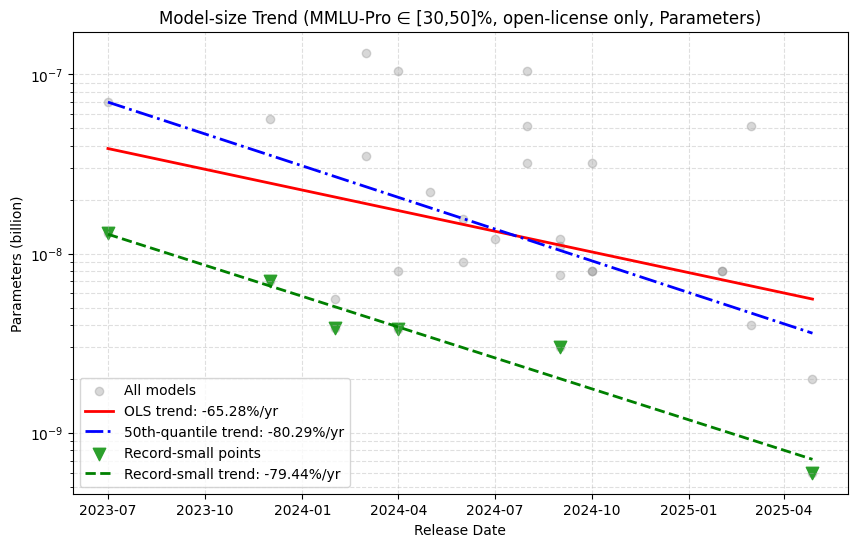

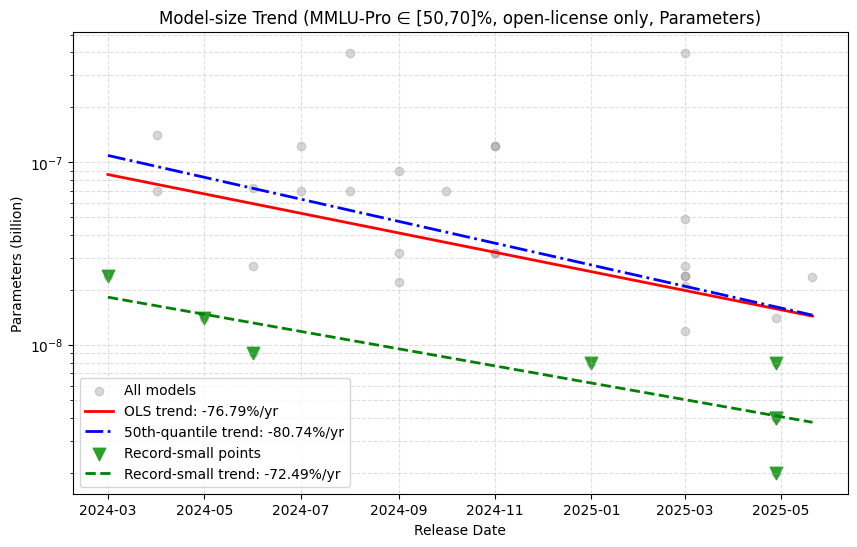

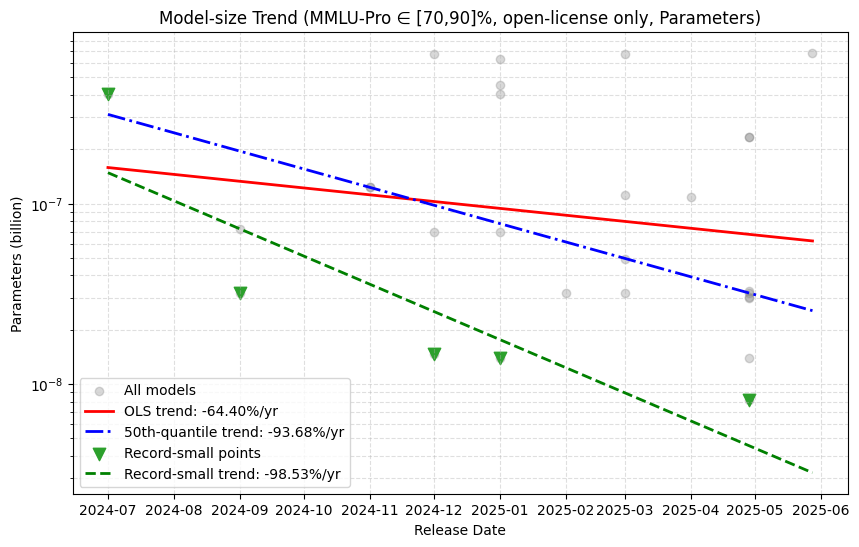

In [46]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=False)
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=False)
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=False)


## Active Parameters

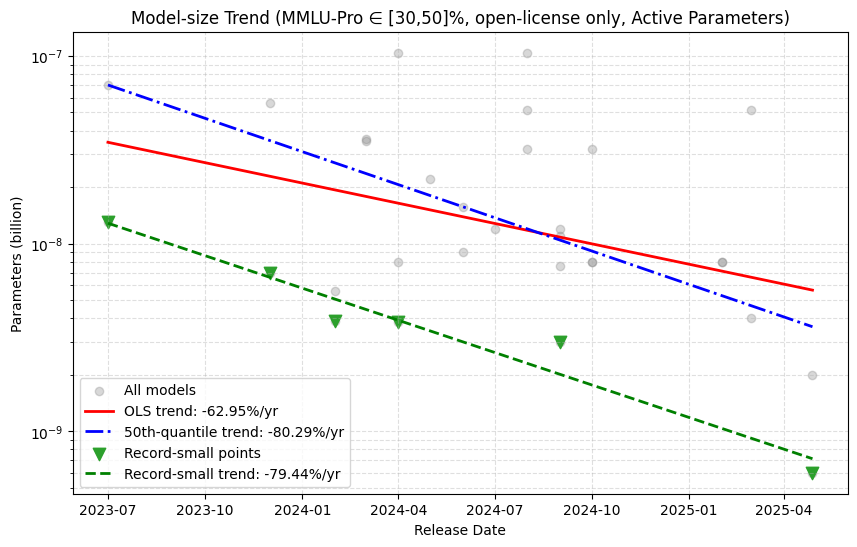

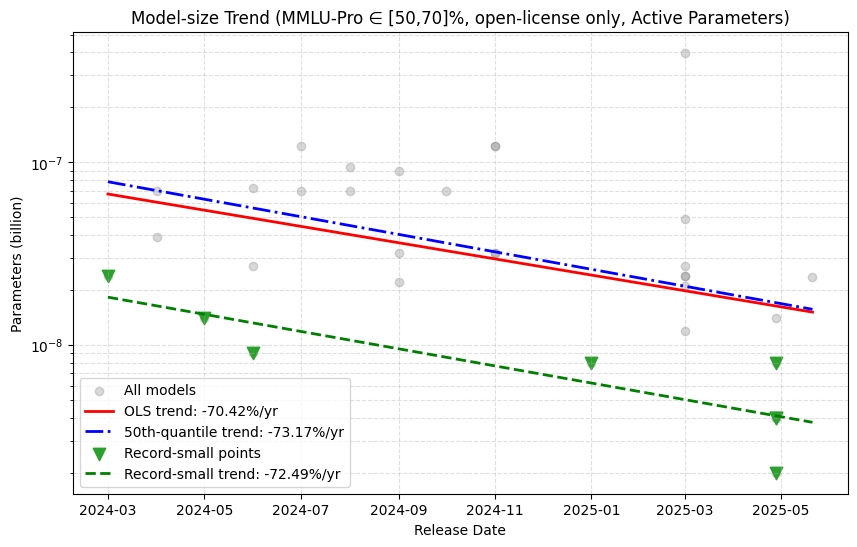

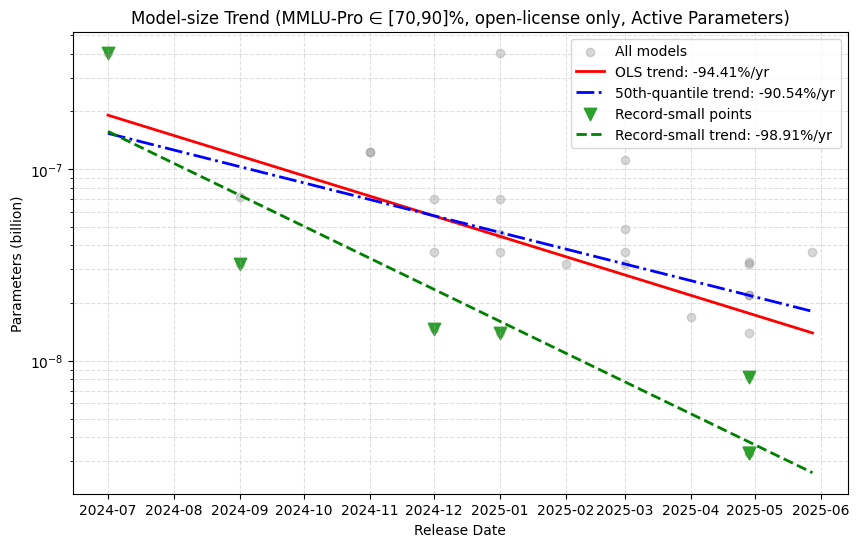

In [47]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=True)
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=True)
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=True)


# Parameters Per Dollar

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, QuantileRegressor
from datetime import datetime

def plot_params_small_trend_by_mmlu(min_mmlu,
                                    max_mmlu,
                                    open_license_only=False,
                                    benchmark_name='MMLU-Pro (Reasoning & Knowledge)',
                                    use_active_params=False):
    """
    Same inputs as before, but y‐axis = dollars per parameter:
      cost_per_param = (Output Price $/1M tokens) / (# parameters)
    
    Parameters:
    - min_mmlu, max_mmlu: numeric bounds on benchmark_name (%)
    - open_license_only: if True, only include rows where 'License' contains 'open'
    - benchmark_name: column name for the benchmark (default MMLU-Pro)
    - use_active_params: if True, use 'Active Parameters' instead of 'Parameters'
    """
    # 0) Column keys
    mmlu_col    = benchmark_name
    price_col   = 'Output Price\nUSD/1M Tokens'
    param_col   = 'Active Parameters' if use_active_params else 'Parameters'
    license_col = 'License'

    df_work = df.copy()

    # 1) Parse benchmark → float
    df_work[mmlu_col] = (
        df_work[mmlu_col].astype(str)
                         .str.replace('%','',regex=False)
                         .astype(float)
    )
    # 2) Parse price → float ($ per 1M tokens)
    df_work[price_col] = (
        df_work[price_col].astype(str)
                         .str.replace('[$,]','',regex=True)
    )
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    # 3) Parse params → float
    df_work[param_col] = pd.to_numeric(df_work[param_col], errors='coerce')

    # 4) Optional license filter
    if open_license_only:
        df_work = df_work[
            df_work[license_col].str.contains('open', case=False, na=False)
        ]

    # 5) Filter by benchmark range
    df_sub = df_work[df_work[mmlu_col].between(min_mmlu, max_mmlu)].copy()

    # 6) Drop missing / non-positive
    df_sub = df_sub.dropna(subset=['Release Date', price_col, param_col])
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[param_col] > 0)]

    # 7) Compute cost per parameter
    df_sub['Cost_per_Param'] = df_sub[price_col] / df_sub[param_col]

    # 8) Sort & date ordinals
    df_sub = df_sub.sort_values('Release Date')
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)

    # 9) Prepare X, y = log10(cost_per_param)
    X     = df_sub['Date_Ordinal'].values.reshape(-1,1)
    y_log = np.log10(df_sub['Cost_per_Param'].values)

    # 10) Fit overall OLS & median QuantileRegressor
    ols = LinearRegression().fit(X, y_log)
    qr  = QuantileRegressor(quantile=0.5, alpha=0.0).fit(X, y_log)

    # 11) Build prediction grid
    lo, hi    = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range   = np.arange(lo, hi+1)
    x_dates   = [datetime.fromordinal(int(d)) for d in x_range]
    y_ols_log = ols.predict(x_range.reshape(-1,1))
    y_qr_log  = qr.predict(x_range.reshape(-1,1))

    # 12) Compute annualized % growth
    annual_pct_ols = ((10**ols.coef_[0])**365 - 1) * 100
    annual_pct_qr  = ((10**qr.coef_[0])**365 - 1) * 100

    # 13) Identify “record‐small” cost points
    df_sub['Is_Record_Small'] = df_sub['Cost_per_Param'].cummin() == df_sub['Cost_per_Param']
    record_small = df_sub[df_sub['Is_Record_Small']].copy()

    # 14) OLS on record‐small
    X_rec          = record_small['Date_Ordinal'].values.reshape(-1,1)
    y_rec_log      = np.log10(record_small['Cost_per_Param'].values)
    rec_ols        = LinearRegression().fit(X_rec, y_rec_log)
    y_rec_log_pred = rec_ols.predict(x_range.reshape(-1,1))
    annual_pct_rec = ((10**rec_ols.coef_[0])**365 - 1) * 100

    # 15) Plot
    plt.figure(figsize=(10,6))
    # all models
    plt.scatter(df_sub['Release Date'], df_sub['Cost_per_Param'],
                color='gray', alpha=0.3, label='All models')
    # overall OLS
    plt.plot(x_dates, 10**y_ols_log, 'r-', lw=2,
             label=f'OLS trend: {annual_pct_ols:.2f}%/yr')
    # median quantile
    plt.plot(x_dates, 10**y_qr_log, 'b-.', lw=2,
             label=f'50th-quantile: {annual_pct_qr:.2f}%/yr')
    # record‐small points
    plt.scatter(record_small['Release Date'], record_small['Cost_per_Param'],
                color='tab:green', s=80, marker='v',
                label='Record-small cost')
    # record‐small trend
    plt.plot(x_dates, 10**y_rec_log_pred, 'g--', lw=2,
             label=f'Record-small trend: {annual_pct_rec:.2f}%/yr')

    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Cost per parameter\n($ per 1M tokens ÷ # params)')
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    plt.title(f'Cost-per-Param Trend ({mmlu_col} ∈ [{min_mmlu},{max_mmlu}]%, {lic_label})')
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend()
    plt.show()

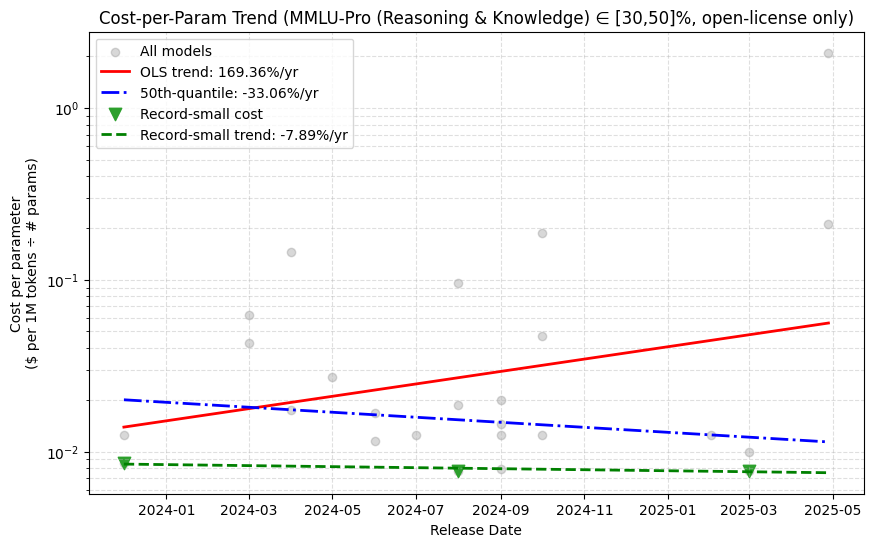

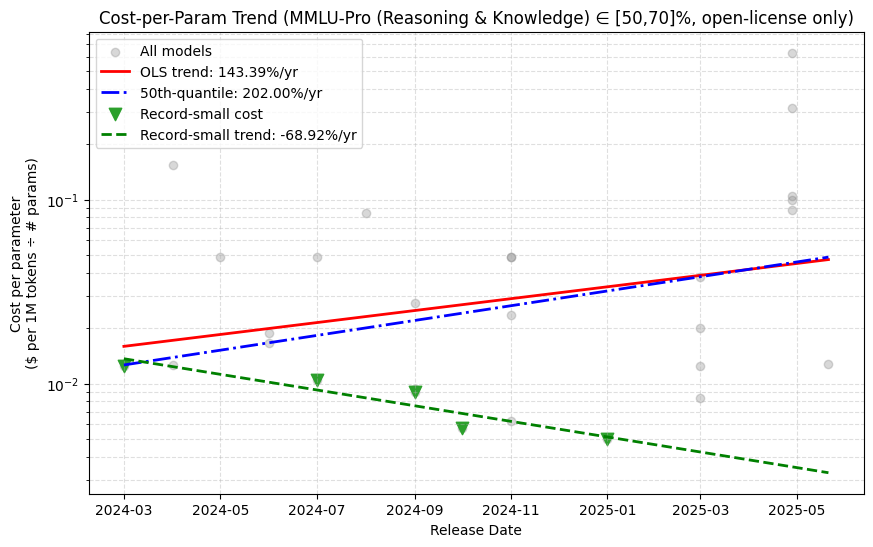

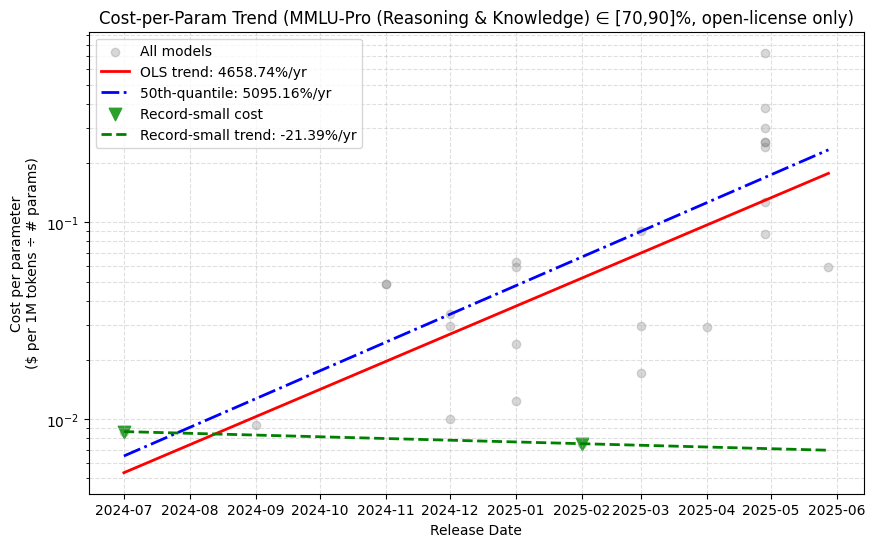

In [52]:
plot_params_small_trend_by_mmlu(30, 50, open_license_only=True, use_active_params=True)
plot_params_small_trend_by_mmlu(50, 70, open_license_only=True, use_active_params=True)
plot_params_small_trend_by_mmlu(70, 90, open_license_only=True, use_active_params=True)